In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import beta
import figure_utils
import matplotlib.pyplot as plt
import statsmodels.api as sm
import bz2
import seaborn as sns
import config
import pickle
plt.style.use("ggplot")

In [3]:
def get_clusters_snv_trajectories(snp_map):
    
    clusters = []
    for key in snp_map.keys():
        clusters.append(snp_map[key][1])
    clusters = list(set(clusters))
    
    freqs = {cluster:[] for cluster in clusters}
    for key in snp_map.keys():
        freqs[list(snp_map[key])[1]].append(np.array(list(snp_map[key])[2]/list(snp_map[key][3])))
    
    for key in freqs.keys():
        freqs[key] = np.array(freqs[key])
        
    return freqs

In [4]:
df = pd.read_csv("/u/home/r/rwolff/dbd/dbd_poyet/Poyet_polymorphism_rates_alpha_divs.csv",index_col=0)
dates = pd.read_pickle("metadata/Poyet_collection_dates.pkl")
dates = pd.DataFrame(dates)
#dates = dates.loc[snp_samples]
dates["Collection_Date"] = pd.to_datetime(dates.Collection_Date)

In [5]:
df_gb = df.groupby(["species_name","subject_id"])

In [33]:
species = "Bacteroides_fragilis_54507"
host = "an"
pi_df = pd.DataFrame(df_gb.get_group((species,host))["polymorphism_rate"])
pi_df["Collection_Date"] = dates["Collection_Date"]
pi_df = pi_df.sort_values("Collection_Date")
pi_df["Date_Diffs"] = pi_df["Collection_Date"].diff().dt.days
pi_df["Date_Diffs"] = pi_df["Date_Diffs"].replace(0.0,.5)
pi_df["Date_Diffs"][0] = 0.0

KeyError: ('Bacteroides_fragilis_54507', 'an')

In [ ]:
timepoints = list(pi_df["Date_Diffs"].cumsum())
pi = list(pi_df["polymorphism_rate"])
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(timepoints,pi,'o');
ax.semilogy()
ax.set_ylim([1e-6,1e-1])
ax.set_ylabel(r"$\pi$",rotation=0,size=25)
ax.set_xlabel("Timepoint",size=25)

In [27]:
#amax = np.argmax(pi)
#pi = list(pi)
#del pi[amax]

In [28]:
pi[np.argmax(pi)]

0.000244914270283

In [29]:
a, b, loc, scale = stats.beta.fit(pi,floc=0,fscale=1)
exp_params = stats.expon.fit(pi)
mu, sigma = stats.norm.fit(pi)

In [30]:
pi = np.array(pi)

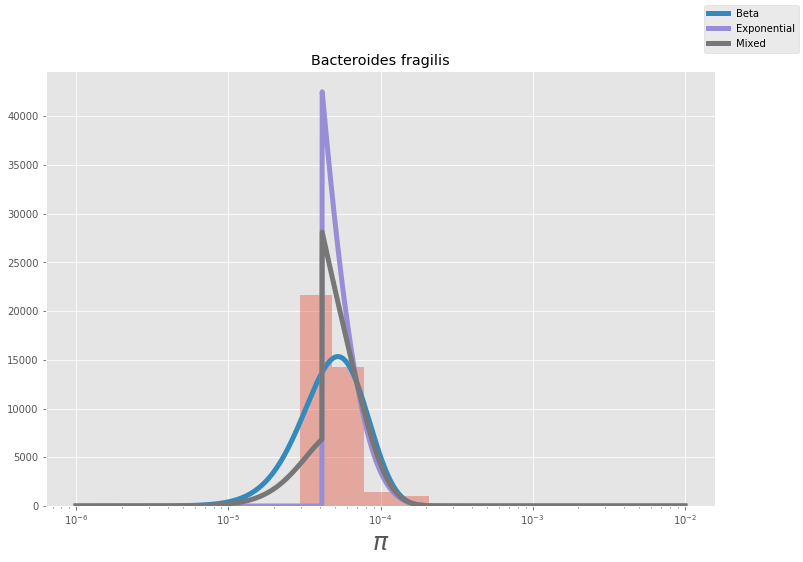

In [31]:
species_name = figure_utils.get_pretty_species_name(species)
fig,ax = plt.subplots(figsize=(12,8))

lower_lim = np.log10(1e-6)
upper_lim = np.log10(1e-2)
numbins = 20
logbins = np.logspace(lower_lim,upper_lim,numbins)
ax.set_title(species_name)
ax.hist(pi, bins=logbins,density=True,alpha=.4)
ax.set_xscale('log')
logx = np.logspace(lower_lim,upper_lim,2000)
ax.plot(logx, stats.beta.pdf(logx, a, b,loc=0,scale=1),linewidth=5,label="Beta")
ax.set_xlabel(r"$\pi$",rotation=0,size=25);

#logbins = np.logspace(np.log10(5*1e-5),np.log10(1e-1),40)
#ax.set_title(species_name)
#ax.hist(pi, bins=logbins,density=True,alpha=.5)
#ax.set_xscale('log')
#logx = np.logspace(np.log10(5*1e-7),np.log10(1e-1),2000)
ax.plot(logx, stats.expon.pdf(logx, exp_params[0], exp_params[1]),linewidth=5,label="Exponential")
ax.plot(logx,(stats.expon.pdf(logx, exp_params[0], exp_params[1])+stats.beta.pdf(logx, a, b,loc=0,scale=1))/2,
       linewidth=5,label="Mixed")
#ax.set_xlabel(r"$\pi$",rotation=0,size=25);
fig.legend();

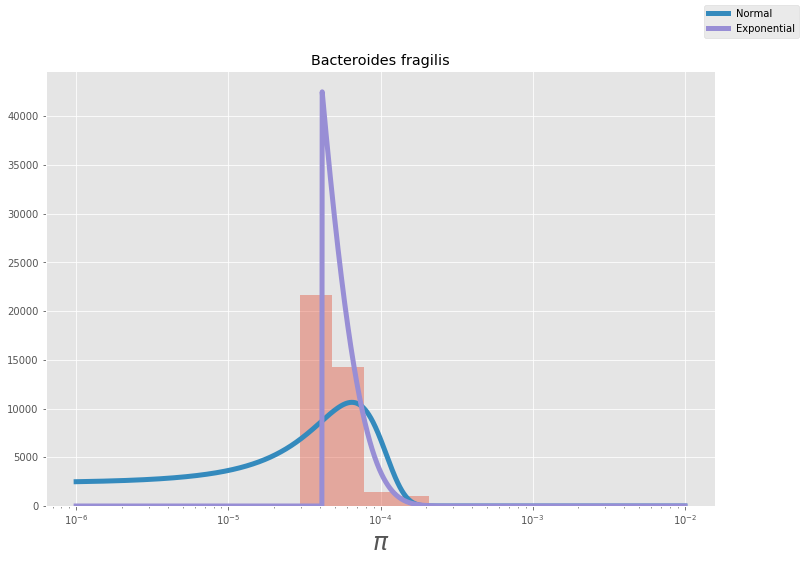

In [32]:
species_name = figure_utils.get_pretty_species_name(species)
fig,ax = plt.subplots(figsize=(12,8))

#logbins = np.logspace(lower_lim,upper_lim,20)
ax.set_title(species_name)
ax.hist(pi, bins=logbins,density=True,alpha=.4)
ax.set_xscale('log')
#logx = np.logspace(np.log10(1e-5),np.log10(1e-1),2000)
ax.plot(logx, stats.norm.pdf(logx, mu,sigma),linewidth=5,label="Normal")
ax.set_xlabel(r"$\pi$",rotation=0,size=25);
#ax.semilogy()
#ax.set_ylim([1e2,1e5])
#logbins = np.logspace(np.log10(5*1e-5),np.log10(1e-1),40)
#ax.set_title(species_name)
#ax.hist(pi, bins=logbins,density=True,alpha=.5)
#ax.set_xscale('log')
#logx = np.logspace(np.log10(5*1e-7),np.log10(1e-1),2000)
ax.plot(logx, stats.expon.pdf(logx, exp_params[0],exp_params[1]),linewidth=5,label="Exponential")
#ax.set_xlabel(r"$\pi$",rotation=0,size=25);
fig.legend();

0.9405296850671926


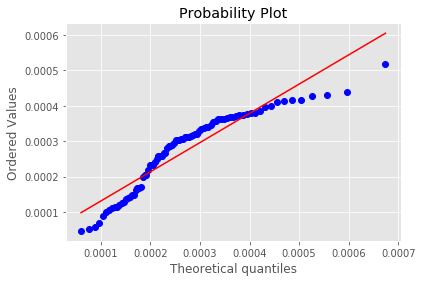

In [14]:
stats.probplot(pi, plot=plt,dist=stats.beta,sparams=(a, b, loc, scale));
print(stats.probplot(pi, dist=stats.beta,sparams=(a, b, loc, scale))[1][-1])
#plt.loglog();

0.9803151778080921


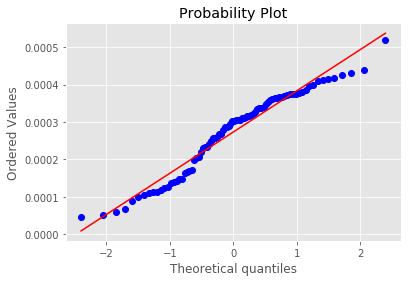

In [15]:
stats.probplot(pi, plot=plt,dist=stats.norm);
print(stats.probplot(pi, dist=stats.norm)[1][-1])
#plt.loglog();
#plt.semilogx();

0.853162281396404


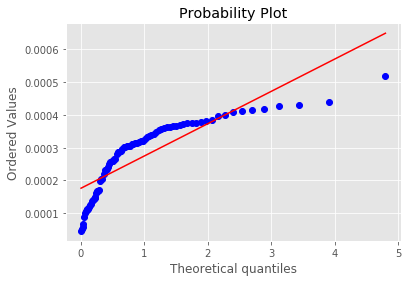

In [16]:
stats.probplot(pi, plot=plt,dist=stats.expon);
print(stats.probplot(pi, dist=stats.expon)[1][-1]);

In [17]:
output_directory = "/u/scratch/r/rwolff/strainfinder_input/%s" % host
filename_prefix = "%s/%s" % (output_directory, species)
snp_locations = pickle.load(open(filename_prefix+".strainfinder.locations.p",'rb'))
snp_alignment = pd.read_pickle(filename_prefix+".strainfinder.p")
snp_samples = pickle.load(open(filename_prefix+".strainfinder.samples.p",'rb'))
outp=pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_strain_frequencies.pkl")

cluster_As = snp_alignment[:,:,0].T
cluster_Ds = (snp_alignment.sum(axis=2)).T

good_inds = cluster_Ds.mean(axis=0) > 2

snp_map = pd.read_pickle(f"~/diversity_ecology/analysis/clusters/{host}/{species}_snp_map.pkl")
freqs = get_clusters_snv_trajectories(snp_map)

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [18]:
snp_samples = [elem.decode("utf8") for elem in snp_samples]

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


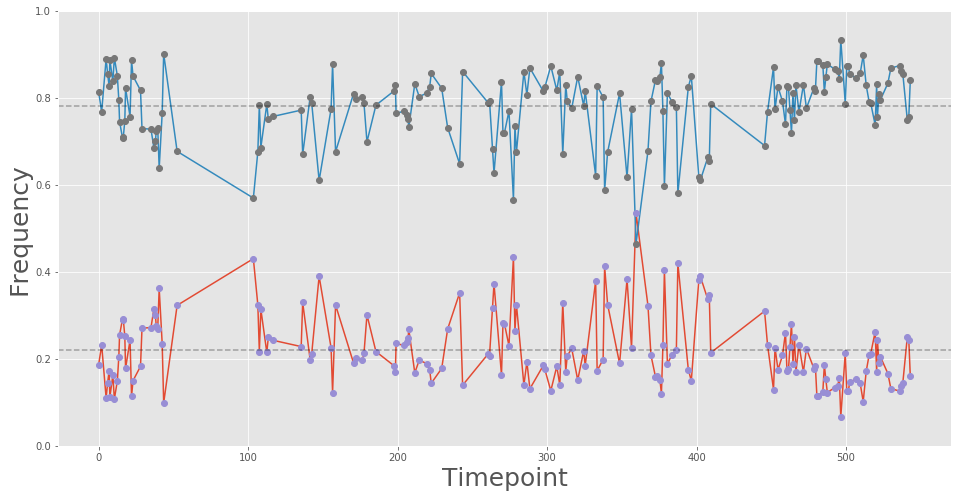

In [19]:
strain_df = pd.DataFrame(index=snp_samples,columns=outp.keys())
for K in outp.keys():
    strain_freq_est = outp[K]["centroid"][0]
    strain_df[K] = strain_freq_est
strain_df["Collection_Date"] = dates["Collection_Date"]
strain_df = strain_df.sort_values("Collection_Date")
strain_df["Date_Diffs"] = strain_df["Collection_Date"].diff().dt.days
strain_df["Date_Diffs"] = strain_df["Date_Diffs"].replace(0.0,.5)
strain_df["Date_Diffs"][0] = 0.0
strain_df["Order"] = range(strain_df.shape[0])
sample_order = np.array(list(strain_df.loc[snp_samples]["Order"]))
idx = np.empty_like(sample_order)
idx[sample_order] = np.arange(len(sample_order))
strain_freqs = pd.DataFrame(index=strain_df.index,columns=outp.keys())

strain_freqs[list(outp.keys())] = strain_df[outp.keys()]
out_strain_num = max(list(outp.keys())) + 1
strain_freqs[out_strain_num] = 1 - strain_freqs.T.sum()
times = np.array(list(strain_df["Date_Diffs"].cumsum()))

fig,ax = plt.subplots(figsize=(16,8))

ax.plot(times, strain_freqs.values)
ax.plot(times, strain_freqs.values,'o')

for elem in list(strain_freqs.mean()):
    ax.axhline(elem,linestyle="--",c="k",alpha=.3)

ax.set_ylim([0,1])
ax.set_xlabel("Timepoint",size=25)
ax.set_ylabel("Frequency",size=25);

Text(0.5, 0, 'Frequency')

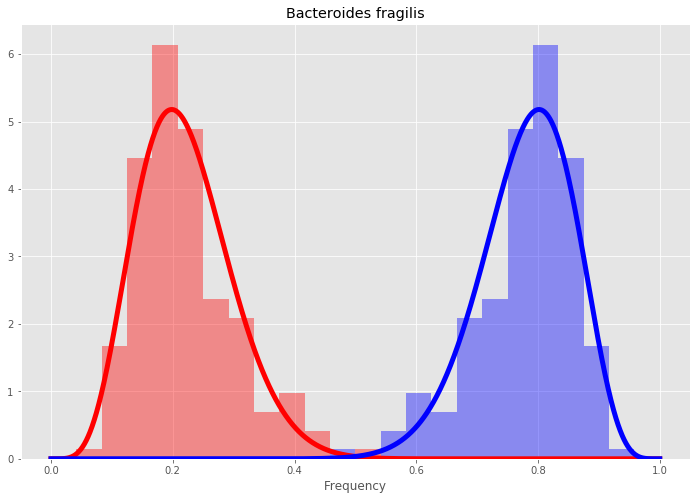

In [20]:
f1 = strain_freqs.values[:,0]
a1, b1, loc1, scale1 = stats.beta.fit(f1,floc=0,fscale=1)
species_name = figure_utils.get_pretty_species_name(species)
fig,ax = plt.subplots(figsize=(12,8))

lower_lim = 0
upper_lim = 1e-0
numbins = 25
#logbins = np.logspace(lower_lim,upper_lim,numbins)
linbins = np.linspace(lower_lim,upper_lim,numbins)

#lin
ax.set_title(species_name)
ax.hist(f1, bins=linbins,density=True,alpha=.4,color="red")
#ax.set_xscale('log')
#logx = np.logspace(lower_lim,upper_lim,2000)
linx = np.linspace(lower_lim,upper_lim,2000)
ax.plot(linx, stats.beta.pdf(linx, a1, b1,loc=0,scale=1),linewidth=5,color="red")

f2 = strain_freqs.values[:,1]
a2, b2, loc2, scale2 = stats.beta.fit(f2,floc=0,fscale=1)
#species_name = figure_utils.get_pretty_species_name(species)
#fig,ax = plt.subplots(figsize=(12,8))

#lower_lim = np.log10(1e-1)
#upper_lim = np.log10(1e-0)
#numbins = 25
#logbins = np.logspace(lower_lim,upper_lim,numbins)
#ax.set_title(species_name)
ax.hist(f2, bins=linbins,density=True,alpha=.4,color="blue")
#ax.set_xscale('log')
#logx = np.logspace(lower_lim,upper_lim,2000)
ax.plot(linx, stats.beta.pdf(linx, a2, b2,loc=0,scale=1),linewidth=5,color="blue")

ax.set_xlabel("Frequency")

In [21]:
a1, b1

(6.092748361092069, 21.584856062604246)

In [22]:
a2, b2

(21.58485606260343, 6.092748361091674)

In [23]:
rel_ab = pd.read_csv("/u/scratch/r/rwolff/merged_MIDAS_output/%s/species/relative_abundance.txt" % host,sep="\t",index_col=0)
spec_rel_ab = rel_ab.loc[species]
spec_rel_ab = spec_rel_ab.loc[strain_df.index]
cov = pd.read_csv(f"~/dbd/analysis/sample_covariates_{host}.txt",index_col=0,sep="\t")

In [24]:
N = cov["total_reads_MIDAS"].mean()
strain_abs = strain_freqs.T*spec_rel_ab
s1 = strain_abs.loc[1]
s2 = strain_abs.loc[2]

In [65]:
lower_lim = .95*min(s1)
upper_lim = 1.05*max(s1)
ab_x = np.logspace(np.log10(lower_lim),np.log10(upper_lim),1000,endpoint=False)
linbins = np.logspace(np.log10(lower_lim),np.log10(upper_lim),20,endpoint=False)
fit_alpha1, fit_loc1, fit_beta1=stats.gamma.fit(s1,floc=0)
fit_mu1, fit_sigma1 = stats.norm.fit(s1)

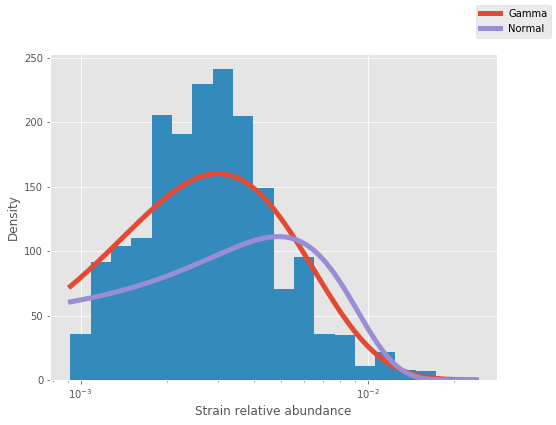

In [66]:
fig,ax = plt.subplots(figsize=(8,6))
ax.plot(ab_x,stats.gamma.pdf(ab_x,fit_alpha1, fit_loc1, fit_beta1),linewidth=5,label="Gamma")
ax.hist(s1,bins=linbins,density=True,label=None);
ax.plot(ab_x, stats.norm.pdf(ab_x, fit_mu1, fit_sigma1),linewidth=5,label="Normal");

#ax.loglog()
ax.semilogx();
#ax.set_xlim([10**lower_lim,10**upper_lim])

ax.set_ylabel("Density")

ax.set_xlabel("Strain relative abundance")

#ax.set_ylim([1e-5,1e-3])
fig.legend();

In [67]:
lower_lim2 = .9*np.log10(min(s2))
upper_lim2 = 1.05*np.log10(max(s2))
ab_x2 = np.logspace(lower_lim2,upper_lim2,1000,endpoint=False)
logbins2 = np.logspace(lower_lim2,upper_lim2,20,endpoint=False)

In [69]:
fit_alpha2, fit_loc2, fit_beta2=stats.gamma.fit(s2,floc=0)
fit_mu2, fit_sigma2 = stats.norm.fit(s2)

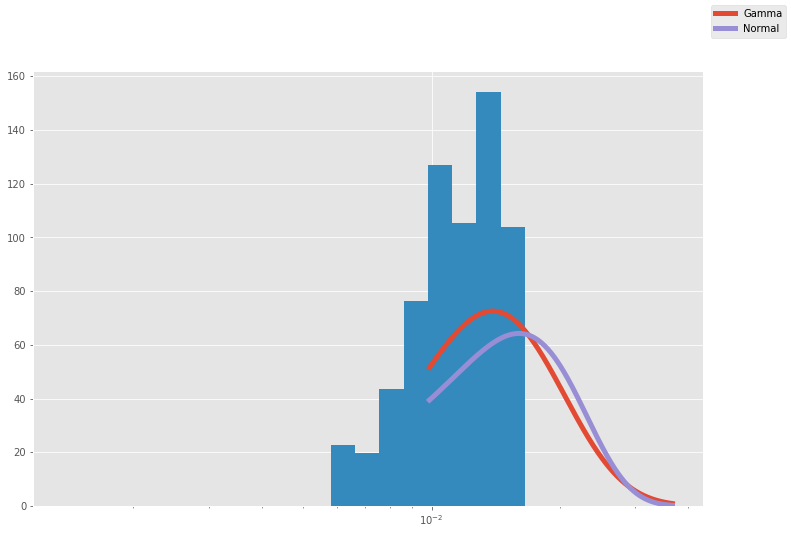

In [71]:
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(ab_x2,stats.gamma.pdf(ab_x2,fit_alpha2, fit_loc2, fit_beta2),linewidth=5,label="Gamma")
ax.hist(s2,bins=logbins,density=True,label=None);
ax.plot(ab_x2, stats.norm.pdf(ab_x2, fit_mu2, fit_sigma2),linewidth=5,label="Normal");
ax.semilogx();
#ax.set_xlim([10**lower_lim2,10**upper_lim2])
fig.legend();
#=ax.loglog();

In [538]:
fit_alpha2, fit_loc2, fit_beta2

(0.4691217024325238, 18.807725009427628, 338.7216031919577)

In [539]:
fit_alpha1, fit_loc1, fit_beta1

(1.3767608584840487, 54.9681263731368, 375.6160193872056)

In [275]:
pi = strain_freqs.values*(1-strain_freqs.values)
pi = pi[:,0]

In [276]:
freqs = get_clusters_snv_trajectories(snp_map)

/u/local/apps/python/3.7.2/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [277]:
freqs.keys()

dict_keys([1])

In [278]:
num_snps = freqs[1].shape[0]

In [279]:
num_snps

28125

In [280]:
f_mat = strain_freqs.values

NameError: name 'count' is not defined

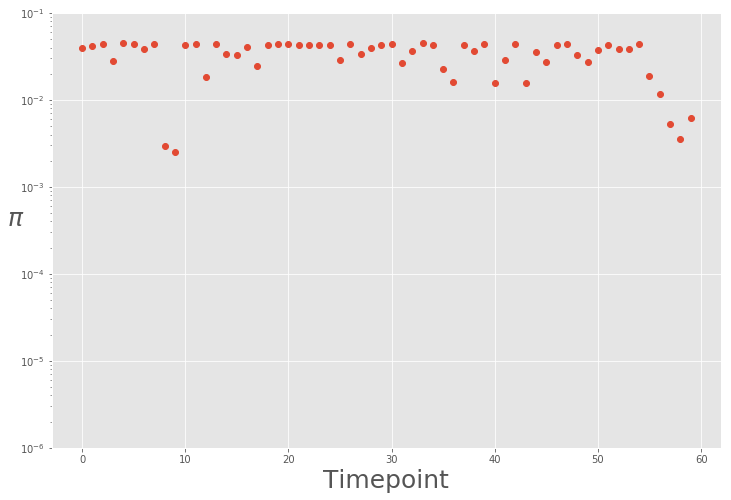

In [281]:
timepoints = list(pi_df["Date_Diffs"].cumsum())
pi = list(pi_df["polymorphism_rate"])
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(pi,'o');
ax.semilogy()
ax.set_ylim([1e-6,1e-1])
ax.set_ylabel(r"$\pi$",rotation=0,size=25)
ax.set_xlabel("Timepoint",size=25)
ax.plot(2*(num_snps/count)*(f_mat[:,0]*f_mat[:,1]),'o')

In [282]:
plt.plot(2*(num_snps/count)*(f_mat[:,0]*f_mat[:,1]),'o')

NameError: name 'count' is not defined

In [283]:
df = pd.read_csv(f"/u/scratch/r/rwolff/merged_MIDAS_output/{host}/snps/{species}/snps_summary.txt",sep="\t",index_col=0)

In [284]:
num_snps/df["covered_bases"]

sample_id
SRR9224004    0.011191
SRR9224005    0.011279
SRR9224006    0.011130
SRR9224133    0.011250
SRR9224134    0.010975
SRR9224136    0.011391
SRR9224137    0.011117
SRR9224138    0.011124
SRR9224139    0.010946
SRR9224140    0.011051
SRR9224142    0.011230
SRR9224143    0.011114
SRR9224184    0.010911
SRR9224187    0.010927
SRR9224203    0.011136
SRR9224234    0.011120
SRR9224235    0.011006
SRR9224236    0.011119
SRR9224237    0.011385
SRR9224238    0.010924
SRR9224240    0.011017
SRR9224241    0.011095
SRR9224242    0.011006
SRR9224273    0.011060
SRR9224274    0.011212
SRR9224275    0.010974
SRR9224276    0.010988
SRR9224277    0.011162
SRR9224278    0.011154
SRR9224279    0.011074
SRR9224280    0.011224
SRR9224282    0.011181
SRR9224283    0.011007
SRR9224313    0.010802
SRR9224314    0.010951
SRR9224317    0.011058
SRR9224318    0.010721
SRR9224321    0.011035
SRR9224322    0.011083
SRR9224323    0.010968
SRR9224324    0.011000
SRR9224325    0.011014
SRR9224327    0.010966
S

In [285]:
p=2*(num_snps/df["covered_bases"])*(strain_freqs[1]*(1-strain_freqs[1]) + strain_freqs[2]*(1-strain_freqs[2])
                                   + strain_freqs[3]*(1-strain_freqs[3]))

KeyError: 3

In [286]:
df["covered_bases"]

sample_id
SRR9224004    2513078
SRR9224005    2493649
SRR9224006    2526952
SRR9224133    2499899
SRR9224134    2562758
SRR9224136    2468982
SRR9224137    2529878
SRR9224138    2528361
SRR9224139    2569416
SRR9224140    2545045
SRR9224142    2504525
SRR9224143    2530700
SRR9224184    2577766
SRR9224187    2573935
SRR9224203    2525626
SRR9224234    2529119
SRR9224235    2555463
SRR9224236    2529408
SRR9224237    2470436
SRR9224238    2574544
SRR9224240    2552871
SRR9224241    2535009
SRR9224242    2555515
SRR9224273    2542860
SRR9224274    2508425
SRR9224275    2562832
SRR9224276    2559514
SRR9224277    2519669
SRR9224278    2521588
SRR9224279    2539704
SRR9224280    2505771
SRR9224282    2515394
SRR9224283    2555250
SRR9224313    2603792
SRR9224314    2568345
SRR9224317    2543322
SRR9224318    2623415
SRR9224321    2548768
SRR9224322    2537649
SRR9224323    2564238
SRR9224324    2556721
SRR9224325    2553453
SRR9224327    2564735
SRR9224448    2543243
SRR9224449    2514036


In [287]:
np.nanmean((freqs[1] * (1 - freqs[1]))[:,0])*(len(freqs[1])/df["covered_bases"])

sample_id
SRR9224004    0.002441
SRR9224005    0.002460
SRR9224006    0.002428
SRR9224133    0.002454
SRR9224134    0.002394
SRR9224136    0.002485
SRR9224137    0.002425
SRR9224138    0.002426
SRR9224139    0.002388
SRR9224140    0.002410
SRR9224142    0.002449
SRR9224143    0.002424
SRR9224184    0.002380
SRR9224187    0.002383
SRR9224203    0.002429
SRR9224234    0.002426
SRR9224235    0.002401
SRR9224236    0.002425
SRR9224237    0.002483
SRR9224238    0.002383
SRR9224240    0.002403
SRR9224241    0.002420
SRR9224242    0.002401
SRR9224273    0.002413
SRR9224274    0.002446
SRR9224275    0.002394
SRR9224276    0.002397
SRR9224277    0.002435
SRR9224278    0.002433
SRR9224279    0.002416
SRR9224280    0.002448
SRR9224282    0.002439
SRR9224283    0.002401
SRR9224313    0.002356
SRR9224314    0.002389
SRR9224317    0.002412
SRR9224318    0.002338
SRR9224321    0.002407
SRR9224322    0.002418
SRR9224323    0.002392
SRR9224324    0.002399
SRR9224325    0.002403
SRR9224327    0.002392
S

In [288]:
df["covered_bases"]

sample_id
SRR9224004    2513078
SRR9224005    2493649
SRR9224006    2526952
SRR9224133    2499899
SRR9224134    2562758
SRR9224136    2468982
SRR9224137    2529878
SRR9224138    2528361
SRR9224139    2569416
SRR9224140    2545045
SRR9224142    2504525
SRR9224143    2530700
SRR9224184    2577766
SRR9224187    2573935
SRR9224203    2525626
SRR9224234    2529119
SRR9224235    2555463
SRR9224236    2529408
SRR9224237    2470436
SRR9224238    2574544
SRR9224240    2552871
SRR9224241    2535009
SRR9224242    2555515
SRR9224273    2542860
SRR9224274    2508425
SRR9224275    2562832
SRR9224276    2559514
SRR9224277    2519669
SRR9224278    2521588
SRR9224279    2539704
SRR9224280    2505771
SRR9224282    2515394
SRR9224283    2555250
SRR9224313    2603792
SRR9224314    2568345
SRR9224317    2543322
SRR9224318    2623415
SRR9224321    2548768
SRR9224322    2537649
SRR9224323    2564238
SRR9224324    2556721
SRR9224325    2553453
SRR9224327    2564735
SRR9224448    2543243
SRR9224449    2514036


In [289]:
pi1=np.array([np.nanmean((freqs[2] * (1 - freqs[2]))[:,i]) for i in range(205)])

KeyError: 2

In [290]:
pi1*len(freqs[2])/np.array(list(df["covered_bases"]))

NameError: name 'pi1' is not defined

In [291]:
freqs

{1: array([[0.75      , 0.6875    , 0.90909091, ..., 1.        , 0.72727273,
         0.55172414],
        [0.375     , 0.66666667, 0.75      , ..., 0.4       , 0.66666667,
         0.45454545],
        [       nan,        nan, 1.        , ..., 0.85714286,        nan,
                nan],
        ...,
        [0.33333333, 0.52      , 0.76470588, ..., 0.76      , 0.5       ,
         0.72972973],
        [0.32      , 0.16666667, 0.5625    , ..., 0.53333333, 0.44444444,
         0.3       ],
        [0.66666667, 0.76470588, 0.8       , ..., 0.52631579, 0.5       ,
         0.6744186 ]])}

NameError: name 'p' is not defined

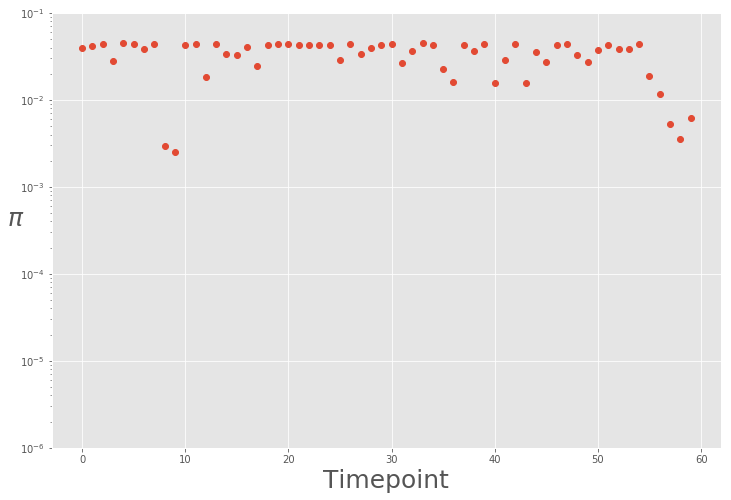

In [292]:
timepoints = list(pi_df["Date_Diffs"].cumsum())
pi = list(pi_df["polymorphism_rate"])
fig,ax = plt.subplots(figsize=(12,8))
ax.plot(pi,'o');
ax.semilogy()
ax.set_ylim([1e-6,1e-1])
ax.set_ylabel(r"$\pi$",rotation=0,size=25)
ax.set_xlabel("Timepoint",size=25);
ax.plot(list(3*p),"o")